<a href="https://colab.research.google.com/github/yerinsally/BDA/blob/main/%EC%A0%95%EC%98%88%EB%A6%B0_0219_%EB%B3%B5%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FbProhet 
- 시계열분석
- 참고 링크 : https://www.facebook.com/gpa/facebook-protect
- pip install prophet

  pip install fbprophet

  no module 

  pip install 모듈 

  3.6 버전 
  - 본인 파이썬 버전 체크하고 
  - 버전 업그레이드를 해야 한다.

In [1]:
# import necessary libraries
import numpy as np 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
#from plotnine import *
import io
# to predictive A
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDAA 5기/data/sales_data.csv', encoding='unicode_escape')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


### Prophet은 
1. 변수가 필요없다. 
2. 시계열과 y값(예측값)만 필요하다.
- prophet을 사용할 때 특정 컬럼으로 만들어야 함!

실제로 미래의 값을 예측해서 미래에 그 값이 나오는지 확인

In [4]:
pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
df['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 541909, dtype: datetime64[ns]

### 총 주문 예측

In [7]:
# 예측 데이터 새로 만들기
df_1 = df.copy()
df_1 = df_1[df_1.Quantity > 0] # 수량이 마이너스인 값 제거
df_1 = df_1[df_1.UnitPrice > 0] # 가격이 마이너스인 값 제거
df_1['Q_price'] = df_1['Quantity'] * df_1['UnitPrice']
df_1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Q_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [8]:
# 두 가지 변수만 가지고 시계열을 예측
df_1 = df_1[['InvoiceDate','Q_price']]
df_1

,InvoiceDate,Q_price
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34
...,...,...
541904,2011-12-09 12:50:00,10.20
541905,2011-12-09 12:50:00,12.60
541906,2011-12-09 12:50:00,16.60
541907,2011-12-09 12:50:00,16.60


In [9]:
# Prpphet은 컬럼의 이름 바꿔줘야 함
# ds : 시계열값, y : 예측값
df_1.rename(columns={'InvoiceDate':'ds','Q_price':'y'},inplace=True)
df_1

,ds,y
0,2010-12-01 08:26:00,15.30
1,2010-12-01 08:26:00,20.34
2,2010-12-01 08:26:00,22.00
3,2010-12-01 08:26:00,20.34
4,2010-12-01 08:26:00,20.34
...,...,...
541904,2011-12-09 12:50:00,10.20
541905,2011-12-09 12:50:00,12.60
541906,2011-12-09 12:50:00,16.60
541907,2011-12-09 12:50:00,16.60


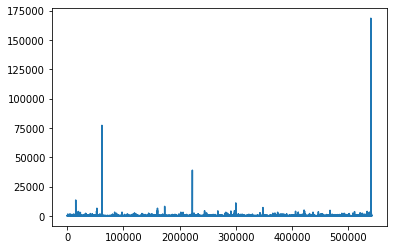

In [10]:
df_1.y.plot()

- 축을 조정해서 트렌드가 어떤 경향을 보이는지 꼭 확인
- 시계열데이터는 결국 과거에 대한 패턴을 학습하여 미래를 예측 
  - 과거 데이터로 지금까지 트렌드가 우상향(증가)인지, 우하향(감소)인지 
  - 실제값이 나왔을 때 트렌드와 함께 비교해서 결과가 맞는지

In [17]:
# ds를 인덱스로 넣어보기
df_1 = df_1.set_index('ds')

df_2 = df_1.resample('D').sum()
df_2

,y
ds,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95
...,...
2011-12-05,88741.96
2011-12-06,56713.21
2011-12-07,75439.16


In [18]:
df_2.reset_index(inplace=True) # 인덱스 풀기
df_2

,ds,y
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-04,0.00
4,2010-12-05,31774.95
...,...,...
369,2011-12-05,88741.96
370,2011-12-06,56713.21
371,2011-12-07,75439.16
372,2011-12-08,82495.00


In [19]:
# train / test 셋으로 나누기
train = df_2[:270]
test = df_2[270:]
print(train, test)

            ds         y
0   2010-12-01  58960.79
1   2010-12-02  47748.38
2   2010-12-03  46943.71
3   2010-12-04      0.00
4   2010-12-05  31774.95
..         ...       ...
265 2011-08-23  25993.68
266 2011-08-24  49035.36
267 2011-08-25  23827.46
268 2011-08-26  25626.44
269 2011-08-27      0.00

[270 rows x 2 columns]             ds          y
270 2011-08-28   10805.03
271 2011-08-29       0.00
272 2011-08-30   31866.31
273 2011-08-31   25380.17
274 2011-09-01   37370.15
..         ...        ...
369 2011-12-05   88741.96
370 2011-12-06   56713.21
371 2011-12-07   75439.16
372 2011-12-08   82495.00
373 2011-12-09  200920.60

[104 rows x 2 columns]


In [20]:
# Prophet으로 시계열 분석을 진행
prophet = Prophet(daily_seasonality = True, 
                  growth = 'linear')
prophet.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvzbbpff5/1fxw0880.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvzbbpff5/wtoiq0qk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70385', 'data', 'file=/tmp/tmpvzbbpff5/1fxw0880.json', 'init=/tmp/tmpvzbbpff5/wtoiq0qk.json', 'output', 'file=/tmp/tmpvzbbpff5/prophet_modelj5q9gjgm/prophet_model-20230221164539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
# 예측
future = prophet.make_future_dataframe(periods=30) # 얼마나 예측할지
forecast = prophet.predict(future)

In [22]:
# 실제 예측한 값
forecast[['ds','yhat']][270:300] 

,ds,yhat
270,2011-08-28,13510.382343
271,2011-08-29,27022.460794
272,2011-08-30,38181.893588
273,2011-08-31,29599.724758
274,2011-09-01,36322.960260
275,2011-09-02,26807.596170
276,2011-09-03,1641.734987
277,2011-09-04,13631.372586
278,2011-09-05,27143.451037
279,2011-09-06,38302.883831


In [23]:
df_2[270:300]

,ds,y
270,2011-08-28,10805.030
271,2011-08-29,0.000
272,2011-08-30,31866.310
273,2011-08-31,25380.170
274,2011-09-01,37370.150
275,2011-09-02,42322.020
276,2011-09-03,0.000
277,2011-09-04,17119.590
278,2011-09-05,37157.140
279,2011-09-06,28349.910


In [24]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-01,52600.800437,15978.795504,48416.282798,52600.800437,52600.800437,-20343.030262,-20343.030262,-20343.030262,-25216.076035,-25216.076035,-25216.076035,4873.045773,4873.045773,4873.045773,0.0,0.0,0.0,32257.770174
1,2010-12-02,52469.817317,24075.208341,56425.189120,52469.817317,52469.817317,-13637.079081,-13637.079081,-13637.079081,-25216.076035,-25216.076035,-25216.076035,11578.996954,11578.996954,11578.996954,0.0,0.0,0.0,38832.738236
2,2010-12-03,52338.834197,12625.194957,45129.914328,52338.834197,52338.834197,-23169.727492,-23169.727492,-23169.727492,-25216.076035,-25216.076035,-25216.076035,2046.348543,2046.348543,2046.348543,0.0,0.0,0.0,29169.106705
3,2010-12-04,52207.851077,-11930.600476,20447.183035,52207.851077,52207.851077,-48352.872995,-48352.872995,-48352.872995,-25216.076035,-25216.076035,-25216.076035,-23136.796960,-23136.796960,-23136.796960,0.0,0.0,0.0,3854.978082
4,2010-12-05,52076.867957,146.797558,30534.199469,52076.867957,52076.867957,-36380.519717,-36380.519717,-36380.519717,-25216.076035,-25216.076035,-25216.076035,-11164.443682,-11164.443682,-11164.443682,0.0,0.0,0.0,15696.348240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2011-09-22,50323.010069,20858.938234,52688.060600,50073.436254,50540.034664,-13637.079081,-13637.079081,-13637.079081,-25216.076035,-25216.076035,-25216.076035,11578.996954,11578.996954,11578.996954,0.0,0.0,0.0,36685.930989
296,2011-09-23,50340.294390,10650.857344,43184.726524,50075.240947,50567.299417,-23169.727492,-23169.727492,-23169.727492,-25216.076035,-25216.076035,-25216.076035,2046.348543,2046.348543,2046.348543,0.0,0.0,0.0,27170.566898
297,2011-09-24,50357.578710,-13966.724499,19611.508938,50076.619024,50599.159175,-48352.872995,-48352.872995,-48352.872995,-25216.076035,-25216.076035,-25216.076035,-23136.796960,-23136.796960,-23136.796960,0.0,0.0,0.0,2004.705715
298,2011-09-25,50374.863031,-2157.276142,29161.538075,50081.631455,50627.046529,-36380.519717,-36380.519717,-36380.519717,-25216.076035,-25216.076035,-25216.076035,-11164.443682,-11164.443682,-11164.443682,0.0,0.0,0.0,13994.343314
